In this project we write an algorithm that estimates the following parametric function:
            $$f(\theta) = (r \cdot \cos(\theta), \ r \cdot \sin(\theta)) + N$$
Where:  
$\theta$ is the input angle (between $0$ and $2\pi$)  
$r$ is the constant radius (in our case $2.5$)  
$N$ is Noise

In [1]:
import torch
from torch import nn 
import matplotlib.pyplot as plt

# Check PyTorch version
print(torch.__version__ )
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

2.7.0+cu126
Using device: cuda


In [8]:
# Create the DATA
r = 2.5
pi = torch.pi
step = 2*pi / 100 # 100 points from 0 to 2pi

angle = torch.arange(0, 2*pi, step)
x = r * torch.cos(angle) + r/100 * torch.randn(angle.size())
y = r * torch.sin(angle) + r/100 * torch.randn(angle.size())
data = torch.stack((x, y), dim=1).to(device)
print(f"Data shape: {data.shape}, Data device: {data.device}")


Data shape: torch.Size([100, 2]), Data device: cuda:0


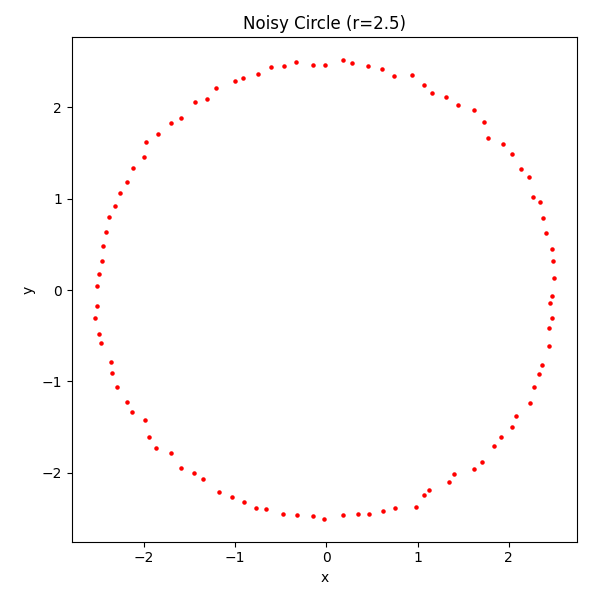

In [ ]:
%matplotlib widget

fig = plt.figure(figsize=(6, 6)) # Set figure size to be square
ax = fig.add_subplot(111) # Standard 2D plot

# 1. Convert tensors to numpy (move to CPU first if on GPU)
# 2. Plot x vs y
ax.scatter(x.cpu().numpy(), y.cpu().numpy(), s=5, c='red')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(f'Noisy Circle (r={r})')

# Important: Force the aspect ratio to be equal so the circle
#  doesn't look like an oval
ax.set_aspect('equal', 'box') 

fig.tight_layout()
plt.show()
#plt.close()


In [14]:
# Split data into training and test sets
# --- 1. Define Split Sizes ---
n_samples = data.shape[0]          # 100
n_train = int(0.8 * n_samples)     # 80
n_test = n_samples - n_train       # 20

# --- 2. Generate Shuffled Indices ---
# This creates a random order (e.g., [4, 92, 12, ...]) so points are mixed
indices = torch.randperm(n_samples)

train_indices = indices[:n_train]
test_indices = indices[n_train:]

# --- 3. Split the Data ---
# Inputs (Angle)
angle_train = angle[train_indices]
angle_test  = angle[test_indices]

# Targets (x, y points)
data_train = data[train_indices]
data_test  = data[test_indices]

print(f"Train shapes: Angle {angle_train.shape}, Data {data_train.shape}")
print(f"Test shapes:  Angle {angle_test.shape},  Data {data_test.shape}")


Train shapes: Angle torch.Size([80]), Data torch.Size([80, 2])
Test shapes:  Angle torch.Size([20]),  Data torch.Size([20, 2])


In [21]:
def plot_predictions_2d(train_data, test_data, predictions=None):
    """
    Plots training data, test data, and optional predictions in 2D.
    Expects inputs of shape (N, 2) where col 0 is x and col 1 is y.
    """
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111)

    # Helper: Convert PyTorch tensors to Numpy arrays (handling GPU/gradients)
    def to_numpy(tensor):
        return tensor.cpu().detach().numpy() if hasattr(tensor, 'cpu') else tensor

    # --- 1. Training Data (Blue/Cyan) ---
    # data[:, 0] is x, data[:, 1] is y
    tr_x = to_numpy(train_data[:, 0])
    tr_y = to_numpy(train_data[:, 1])
    ax.scatter(tr_x, tr_y, c='b', s=10, label='Training data')

    # --- 2. Test Data (Green) ---
    ts_x = to_numpy(test_data[:, 0])
    ts_y = to_numpy(test_data[:, 1])
    ax.scatter(ts_x, ts_y, c='g', s=20, label='Testing data')

    # --- 3. Predictions (Red) ---
    if predictions is not None:
        pred_x = to_numpy(predictions[:, 0])
        pred_y = to_numpy(predictions[:, 1])
        # Using a distinct marker 'x' to see them clearly over the dots
        ax.scatter(pred_x, pred_y, c='r', s=20, label='Predictions', marker='x')

    # Formatting
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Circle Function Estimation')
    
    # Critical for circles: ensures the plot is square
    ax.set_aspect('equal', 'box') 
    
    ax.legend()
    plt.show()

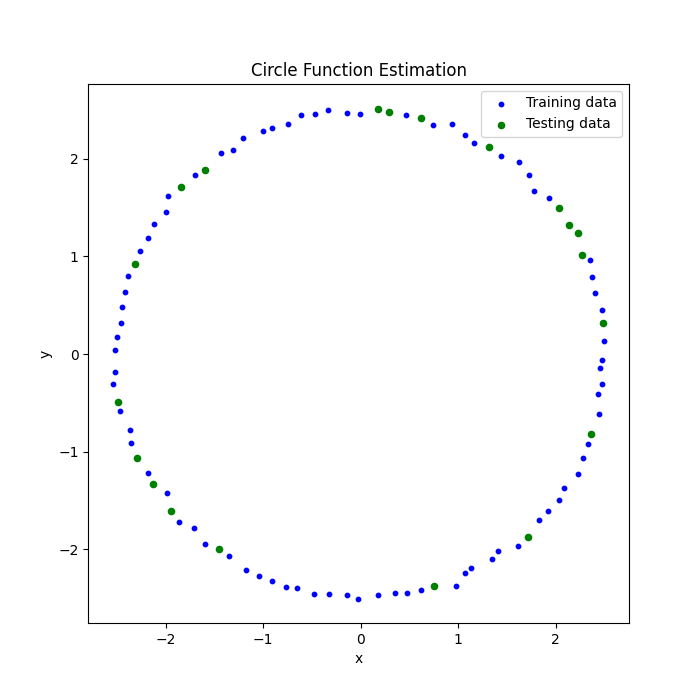

In [22]:
plot_predictions_2d(data_train, data_test)

## Build a PyTorch linear model

In [23]:
# Create the model by subclassing nn.Module
class CircleModelYM(nn.Module):
    def __init__(self):
        super().__init__()
        # We use nn.Sequential to stack layers
        # Input: 1 (angle) -> Hidden Layers -> Output: 2 (x, y coordinates)
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=1, out_features=32), # Hidden layer 1
            nn.ReLU(),                                 # Activation (Non-linearity)
            nn.Linear(in_features=32, out_features=32),# Hidden layer 2
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=2)  # Output layer (x, y)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # If input is 1D [batch], we reshape it to [batch, 1]
        if x.dim() == 1:
            x = x.unsqueeze(dim=1) 
        return self.layer_stack(x)

# Set random seed for reproducibility
torch.manual_seed(42)

# Create an instance of the model and send it to the target device
model_1 = CircleModelYM().to(data.device) # Using data.device to match your data

# Print out the model's structure
print(model_1)

CircleModelYM(
  (layer_stack): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)
